#Description:
    *Merging raw reads with PEAR
    *150622_run2-rerun
  

#Setting variables




In [6]:
seqDir = '/var/seq_data/RhizCG/150622_run2_rerun/raw/'

readFile1 = 'Undetermined_S0_L001_R1_001.fastq.gz'
readFile2 = 'Undetermined_S0_L001_R2_001.fastq.gz'

#Init

In [2]:
import os
import screed
import matplotlib.pyplot as plt
from mpltools import style
import numpy as np
from mpld3 import enable_notebook
import screed
import ggplot

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning: `scipy.linalg.calc_lwork` is deprecated!

calc_lwork was an internal module in Scipy and has been removed.

Several functions in scipy.linalg.lapack have *_lwork variants
that perform the lwork calculation (from Scipy >= 0.15.0), or
allow passing in LWORK=-1 argument to perform the computation.


  warnings.warn(depdoc, DeprecationWarning)


In [3]:
%load_ext pylab
%load_ext rpy2.ipython

The pylab module is not an IPython extension.


In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


##uncompressing 

In [11]:
!cd $seqDir; \
    pigz -k -d -p 24 read?.fq.gz

#Merging

In [12]:
!cd $seqDir; \
    pear -m 500 -j 24 \
    -f read1.fq \
    -r read2.fq \
    -o pear_merged-$(date +%F)

 ____  _____    _    ____ 
|  _ \| ____|  / \  |  _ \
| |_) |  _|   / _ \ | |_) |
|  __/| |___ / ___ \|  _ <
|_|   |_____/_/   \_\_| \_\

PEAR v0.9.2 [March 26 2014]

Citation - PEAR: a fast and accurate Illumina Paired-End reAd mergeR
Zhang et al (2014) Bioinformatics 30(5): 614-620 | doi:10.1093/bioinformatics/btt593

Forward reads file.................: read1.fq
Reverse reads file.................: read2.fq
PHRED..............................: 33
Using empirical frequencies........: YES
Statistical method.................: OES
Maximum assembly length............: 500
Minimum assembly length............: 50
p-value............................: 0.010000
Quality score threshold (trimming).: 0
Minimum read size after trimming...: 1
Maximal ratio of uncalled bases....: 1.000000
Minimum overlap....................: 10
Scoring method.....................: Scaled score
Threads............................: 24

Allocating memory..................: 200,000,000 bytes
Computing empirical frequen

#Making a screed db of merged read

In [13]:
pear_merged_file = !echo "pear_merged-"$(date +%F)".assembled.fastq"
pear_merged_file = pear_merged_file[0]

os.chdir(seqDir)
screed.read_fastq_sequences(pear_merged_file)

pear_merged_file += '_screed'
fqdb = screed.ScreedDB(pear_merged_file)

In [14]:
pear_merged_file = seqDir + 'pear_merged-2015-06-27.assembled.fastq_screed'
fqdb = screed.ScreedDB(pear_merged_file)

In [15]:
pear_merged_file 

'/var/seq_data/RhizCG/150622_run2_rerun/raw/pear_merged-2015-06-27.assembled.fastq_screed'

In [16]:
lengths = []
for read in fqdb.itervalues():
    lengths.append((len(read["sequence"])))

In [25]:
print 'Number of reads: {}'.format(len(lengths))

Number of reads: 3095398


#Quality stats on merged reads

In [26]:
def qualStats(sourceDir, fileName):
    outFile = fileName + '_qualStats'
    !cd $sourceDir; \
        fastx_quality_stats -i $fileName -o $outFile -Q 33
    return outFile
    
qualStatsRes = qualStats(seqDir, 'pear_merged-2015-06-27.assembled.fastq')

In [27]:
qualStatsRes = seqDir + 'pear_merged-2015-06-27.assembled.fastq_qualStats'

In [28]:
%%R -i seqDir -i qualStatsRes

setwd(seqDir)

# reading in qual-stats files    
tbl.r12 = read.delim(qualStatsRes, sep='\t')
rownames(tbl.r12) = 1:nrow(tbl.r12)

In [29]:
%%R
tbl.r12 %>% head

  column   count min max       sum  mean Q1 med Q3 IQR lW rW A_Count C_Count
1      1 3095398  16  40  89823957 29.02 29  29 32   3 25 36  413256  388870
2      2 3095398  16  40  95465021 30.84 29  32 32   3 25 36 2178491  263815
3      3 3095398  16  40 104277560 33.69 29  32 40  11 16 40  315384 2130112
4      4 3095398  16  40 109781739 35.47 32  40 40   8 20 40  988145  292962
5      5 3095398  16  40 106352023 34.36 29  33 40  11 16 40  469261  282938
6      6 3095398  16  40 111455957 36.01 33  37 40   7 23 40 1901710  293254
  G_Count T_Count N_Count Max_count
1  846708 1446564       0   3095398
2  275022  378070       0   3095398
3  266481  383421       0   3095398
4 1455906  358385       0   3095398
5 1474762  868437       0   3095398
6  550695  349739       0   3095398


geom_smooth: method="auto" and size of largest group is <1000, so using loess. Use 'method = x' to change the smoothing method.


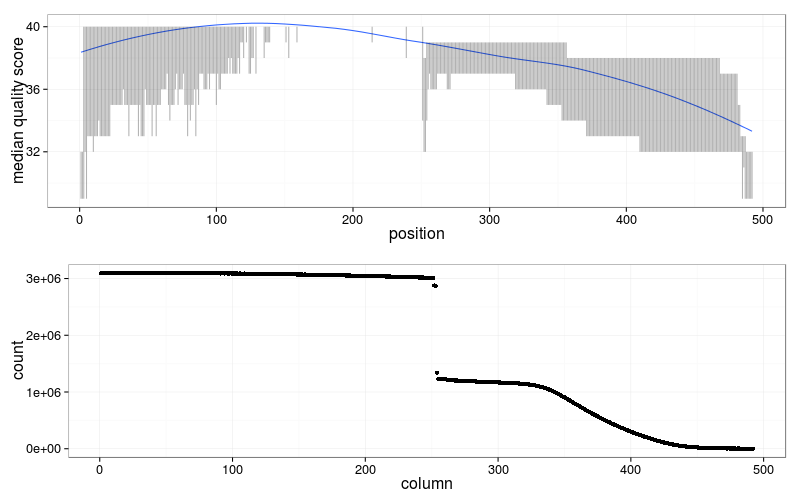

In [30]:
%%R -w 800 -h 500

# smooth curve on median qual values
p1 = ggplot(tbl.r12, aes(x=column, y=med, ymin=Q1, ymax=Q3)) +
    geom_smooth(se=FALSE) +
    geom_linerange(alpha=0.3) +
    labs(x='position', y='median quality score') +
    theme_bw() +
    theme( text = element_text(size=16) )

p2 = ggplot(tbl.r12, aes(x=column, y=count)) +
    geom_point() +
    theme_bw() +
    theme( text = element_text(size=16) )

grid.arrange(p1, p2, ncol=1)

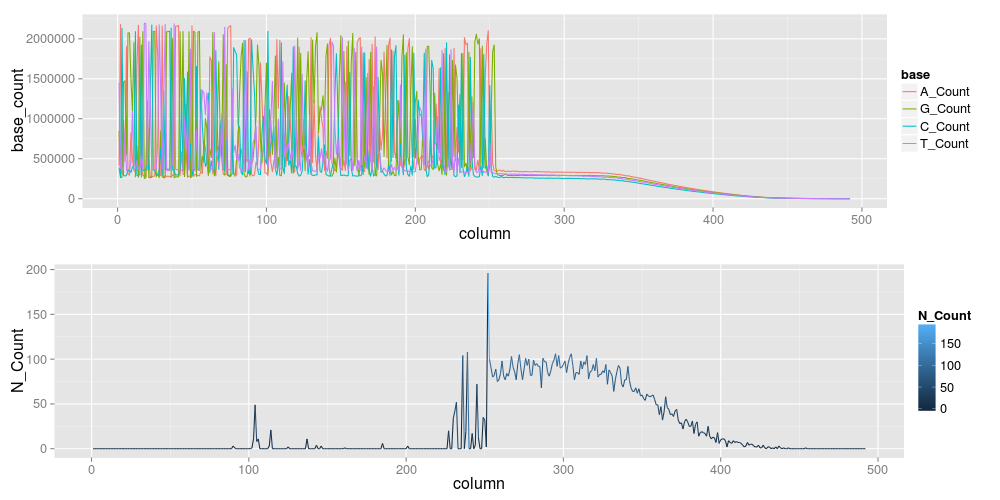

In [31]:
%%R -w 1000 -h 500

tbl.ATGC = tbl.r12 %>%
    select(column, A_Count, G_Count, C_Count, T_Count) %>%
    gather(base, base_count, -column)

tbl.N = tbl.r12 %>%
    select(column, N_Count)


#tbl.ATGC %>% head

p1 = ggplot(tbl.ATGC, aes(x=column, y=base_count, color=base)) +
    geom_line() +
    theme( text = element_text(size=16) )    


p2 = ggplot(tbl.N, aes(x=column, y=N_Count, color=N_Count)) +
    geom_line() +
    theme( text = element_text(size=16) )    

grid.arrange(p1,p2,ncol=1)